<a href="https://colab.research.google.com/github/snv-ds/NLP_course/blob/master/week5/seminar_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today we first will try to implement Attention mechanism and then will try to solve classification task using self-attention mechanism

In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.<br>
We will implement attention scoring as well as calculating an attention context vector.

# Part 1

## Attention scoring

### Inputs to scoring function

Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate):

In [ ]:
dec_hidden_state = [5,1,20]

Let's visualize this vector:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Let's visualize our decoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1);

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [ ]:
annotation = [3,12,45] #e.g. Encoder hidden state

In [ ]:
# Let's visualize the single annotation
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1);

#### Task 1

Calculate the dot product of a single annotation. Return the dot product of the two vectors

In [ ]:
# YOUR CODE HERE
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    return None

In [ ]:
assert single_dot_attention_score(dec_hidden_state, annotation) == 927

#### Annotations matrix

Let's now look at scoring all the annotations at once. To do that, here's our annotation matrix:

In [ ]:
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

In [ ]:
# Let's visualize our annotation (each column is an annotation)
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

#### Task 2

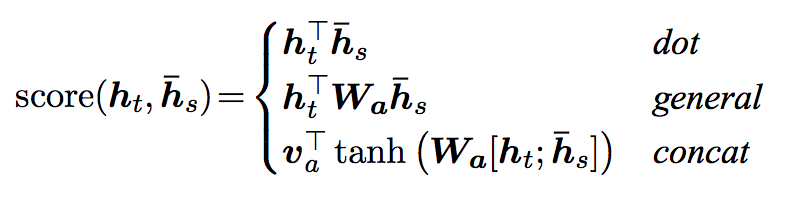

Let's calculate the scores of all the annotations in one step using matrix multiplication. Let's continue to us the dot scoring method.<br>
To do that, we'll have to transpose `dec_hidden_state` and matrix multiply it with `annotations`.<br>

##### help

In [ ]:
# Return the product of dec_hidden_state transpose and enc_hidden_states

##### Continue working

In [ ]:
# YOUR CODE HERE
def dot_attention_score(dec_hidden_state, annotations):
    return None

In [ ]:
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
assert attention_weights_raw[2] == 148
assert attention_weights_raw[0] > 900

In [ ]:
attention_weights_raw

Looking at these scores, can you guess which of the four vectors will get the most attention from the decoder at this time step?

### Softmax

Now that we have our scores, let's apply softmax: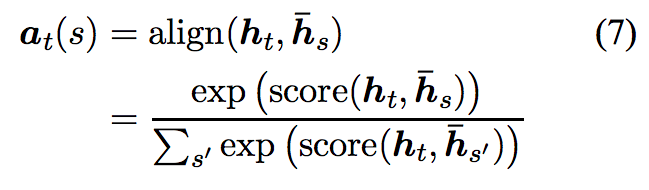

In [ ]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

attention_weights = softmax(attention_weights_raw)

In [ ]:
sum(attention_weights)

In [ ]:
attention_weights

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.12 and 0.88 respectively.

### Applying the scores back on the annotations

Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

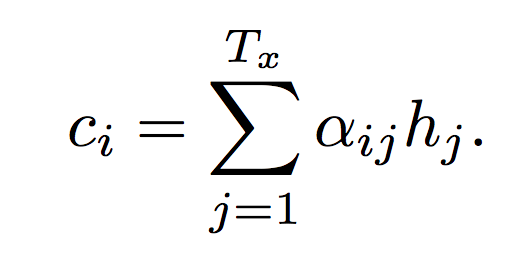

#### Task 3

Multiple the annotations by their weights. As output you must get matrix with vectors, multiplied by each weights.

In [ ]:
# YOUR CODE HERE
def apply_attention_scores(attention_weights, annotations):
    return None

In [ ]:
applied_attention = apply_attention_scores(attention_weights, annotations)

assert applied_attention.shape == (3, 4)
assert applied_attention.sum(axis=0)[0] > 7.1
assert applied_attention.sum(axis=0)[-1] > 45

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

In [ ]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

### Calculating the Attention Context Vector

All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector

In [ ]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

In [ ]:
# Let's visualize the attention context vector
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1);

# Part 2

In this part we will try to implement 2 types of classification models. As base core element of our model we will take 2 different solutions:
- simlpe LSTM 
- self-attention.


We will use IMDB dataset for simplisity. 

In [ ]:
import os
import sys
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import torchtext.legacy as torchtext
from torchtext.vocab import Vectors, GloVe

Library `torchtext` allows us to make Glove-like embeddings from our train data. We can change them on pretrained-vectors if we want.

2 core compenents are 
- `Field` - text of document
- `LabelField` - label of correponding document

In [ ]:
tokenize = lambda x: x.split()
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
LABEL = torchtext.data.LabelField()
train_data, test_data = torchtext.datasets.IMDB.splits(TEXT, LABEL)

Now we can inpace build matrices of vectors for each field

In [ ]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

#### Task 4

Create matrix `word_embeddings` from vectors of `TEXT`.

In [ ]:
# YOUR CODE HERE
word_embeddings = None

In [ ]:
assert word_embeddings.shape[0] == 251639
assert word_embeddings.shape[1] == 300

Now we split our data for train, validation and test part.

In [ ]:
train_data, valid_data = train_data.split() # Further splitting of training_data to create new training_data & validation_data
train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32,
                                                                         sort_key=lambda x: len(x.text),
                                                                         repeat=False, shuffle=True) # we shuffle and sort our samples for loaders

vocab_size = len(TEXT.vocab)

Let's look how to explore data and how BuccketIterator shuffle our data

In [ ]:
' '.join(train_data.examples[0].text)

In [ ]:
' '.join(train_iter.data()[0].text)

#### Task 5

Fill code to complete model initialization

In [ ]:
# YOUR CODE HERE
class LSTMClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(LSTMClassifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = # YOUR CODE
		self.label = # YOUR CODE
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
    input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
    input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
    if batch_size is None:
      h = # initialize zero-vector with dimensionality (1, batch_size, self.hidden_state) and place it on cuda
      c = # initialize zero-vector with dimensionality (1, batch_size, self.hidden_state) and place it on cuda
      h_0 = Variable(h) # Initial hidden state of the LSTM
      c_0 = Variable(c) # Initial cell state of the LSTM
		else:
      h = # initialize zero-vector with dimensionality (1, self.batch_size, self.hidden_state) and place it on cuda
      c = # initialize zero-vector with dimensionality (1, self.batch_size, self.hidden_state) and place it on cuda
      h_0 = Variable(h)
      c_0 = Variable(c)
    output, (final_hidden_state, final_cell_state) = # run forward pass on lstm-layer
    final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
		
    return final_output

In [ ]:
CLIP_VALUE = 1e-1

In [ ]:
def clip_gradient(model, clip_value=CLIP_VALUE):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

#### Task 6

Fill training code

In [ ]:
# YOUR CODE HERE
def train_model(model, train_iter, epoch, loss_fn):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters())) # we fix "pretrained" embeddings
    steps = 0
    # switch model to train mode
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        # zero gradients and make prediction for your model
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        # run backpropogation, clip gradient and then optimize parameters
        steps += 1
        
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)


In [ ]:
def eval_model(model, val_iter, loss_fn):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval() # switch model to evaluation mode (for validation)
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long() # get taget appropriate for torch functions
            if torch.cuda.is_available(): # move tensors to cuda
                text = text.cuda() 
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

#### Task 7

Init model and loss function

In [ ]:
# YOUR CODE HERE
learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

model = None
loss_fn = None

for epoch in range(10):
    train_loss, train_acc = train_model(model, train_iter, epoch, loss_fn)
    val_loss, val_acc = eval_model(model, valid_iter, loss_fn)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')


After training you can validate perfomance of your model on test data and check on your own samples

In [ ]:
test_loss, test_acc = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]

test_sen2 = TEXT.preprocess(test_sen2)
test_sen2 = [[TEXT.vocab.stoi[x] for x in test_sen2]]

test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen, volatile=True)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")

Now we can jump to self-attention model

#### Task 8

We will implement first version of self-attention, that was published in 2017. It is very similar to basic Linear Attention

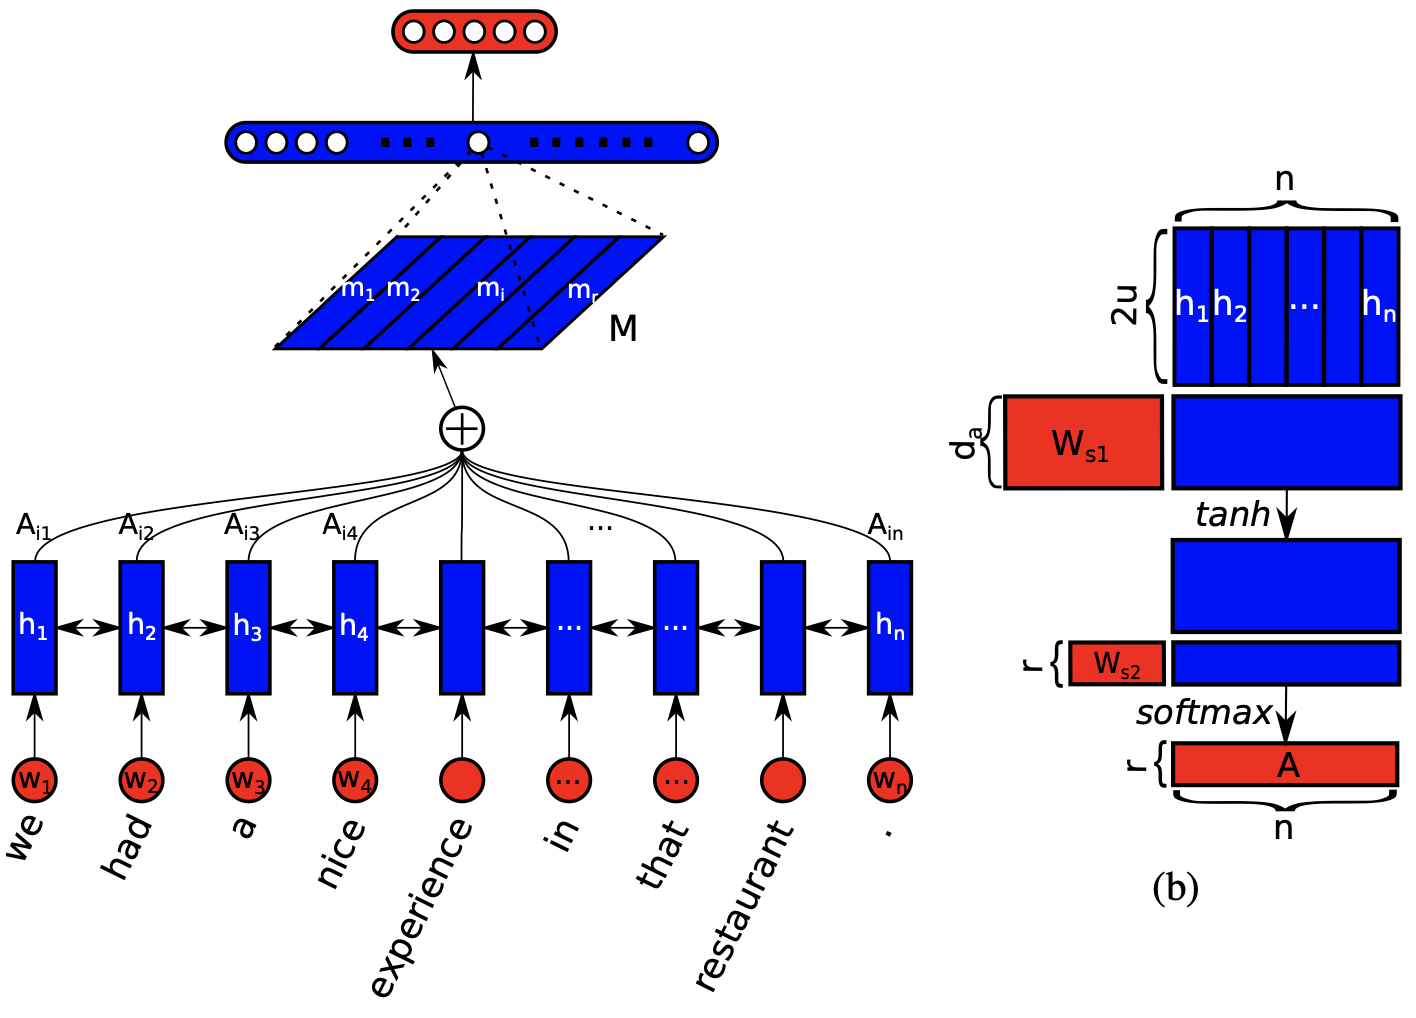

Initialize Linear layers for model

In [ ]:
# YOUR CODE HERE
class SelfAttention(nn.Module): # this is realization of this paper https://arxiv.org/pdf/1703.03130.pdf
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(SelfAttention, self).__init__()

		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		--------
		
		"""

		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		self.weights = weights

		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
		self.dropout = 0.8
		self.bilstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
		# We will use da = 350, r = 30 & penalization_coeff = 1 as per given in the self-attention original ICLR paper
		self.W_s1 = # init linear layer which will gel input from biderectional lstm and out dim must be 350 as in paper
		self.W_s2 = # init linear layer which transition from da (350) dim to r (30) dim 
		self.fc_layer = # init linear layer which transition from r * hidden_size * 2(if previous rnn is bidirectional) size to 2000
		self.label = nn.Linear(2000, output_size)

	def attention_net(self, lstm_output):

		"""
		Now we will use self attention mechanism to produce a matrix embedding of the input sentence in which every row represents an
		encoding of the inout sentence but giving an attention to a specific part of the sentence. We will use 30 such embedding of 
		the input sentence and then finally we will concatenate all the 30 sentence embedding vectors and connect it to a fully 
		connected layer of size 2000 which will be connected to the output layer of size 2 returning logits for our two classes i.e., 
		pos & neg.
		Arguments
		---------
		lstm_output = A tensor containing hidden states corresponding to each time step of the LSTM network.
		---------
		Returns : Final Attention weight matrix for all the 30 different sentence embedding in which each of 30 embeddings give
				  attention to different parts of the input sentence.
		Tensor size : lstm_output.size() = (batch_size, num_seq, 2*hidden_size)
					  attn_weight_matrix.size() = (batch_size, 30, num_seq)
		"""
		attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
		attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
		attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

		return attn_weight_matrix

	def forward(self, input_sentences, batch_size=None):

		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for pos & neg class.
		
		"""

		input = self.word_embeddings(input_sentences)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

		output, (h_n, c_n) = self.bilstm(input, (h_0, c_0))
		output = output.permute(1, 0, 2)
		# output.size() = (batch_size, num_seq, 2*hidden_size)
		# h_n.size() = (1, batch_size, hidden_size)
		# c_n.size() = (1, batch_size, hidden_size)
		attn_weight_matrix = self.attention_net(output)
		# attn_weight_matrix.size() = (batch_size, r, num_seq)
		# output.size() = (batch_size, num_seq, 2*hidden_size)
		hidden_matrix = torch.bmm(attn_weight_matrix, output)
		# hidden_matrix.size() = (batch_size, r, 2*hidden_size)
		# Let's now concatenate the hidden_matrix and connect it to the fully connected layer.
		fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
		logits = self.label(fc_out)
		# logits.size() = (batch_size, output_size)

		return logits

In [ ]:
learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

model = SelfAttention(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
loss_fn = F.cross_entropy

for epoch in range(10):
    train_loss, train_acc = train_model(model, train_iter, epoch, loss_fn)
    val_loss, val_acc = eval_model(model, valid_iter, loss_fn)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')


In [ ]:
test_loss, test_acc = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]

test_sen2 = TEXT.preprocess(test_sen2)
test_sen2 = [[TEXT.vocab.stoi[x] for x in test_sen2]]

test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen, volatile=True)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")